## 1.Import Library dan Dataset


In [ ]:

import pandas as pd, numpy as np
#from pathlib import Path
#base = Path("/mnt/data")
products = pd.read_csv( "/content/products_dataset.csv")
orders = pd.read_csv("/content/orders_dataset.csv")
translations = pd.read_csv("/content/product_category_name_translation.csv")
sellers = pd.read_csv( "/content/sellers_dataset.csv")


## 2.Standarisasi Data

In [ ]:

def standardize_columns(df): #bikin method untuk standarisasi data
    df.columns = [c.strip() for c in df.columns]
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str).str.strip()
    return df


# standarisasi tiap dataset dengan method standardize_columns()
products = standardize_columns(products)
orders = standardize_columns(orders)
translations = standardize_columns(translations)
sellers = standardize_columns(sellers)


## 3. Penggabungan dan Pembersihan Data

In [ ]:

prod = products.merge(translations, on="product_category_name", how="left") #penggabungan data
for c in ["product_length_cm","product_height_cm","product_width_cm","product_weight_g"]:
    prod[c] = pd.to_numeric(prod[c], errors="coerce")

prod["product_volume_cm3"] = prod["product_length_cm"] * prod["product_height_cm"] * prod["product_width_cm"]
prod = prod.drop_duplicates() #hilangkan duplikasi

mask_pos = (prod["product_length_cm"]>0)&(prod["product_height_cm"]>0)&(prod["product_width_cm"]>0)&(prod["product_weight_g"]>0)
prod = prod[mask_pos].copy()

for col in ["product_length_cm","product_height_cm","product_width_cm","product_weight_g","product_volume_cm3"]:
    med_by_cat = prod.groupby("product_category_name")[col].transform("median")
    prod[col] = prod[col].fillna(med_by_cat).fillna(prod[col].median()) #imputasi / ganti data kosong dengan median

prod["product_volume_cm3"] = prod["product_length_cm"] * prod["product_height_cm"] * prod["product_width_cm"]
prod.head() #tampilkan 5 baris teratas di data



,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_volume_cm3
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,2240.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art,10800.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure,2430.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby,2704.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares,4420.0


In [ ]:
prod.isna()


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,product_volume_cm3
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
32946,False,False,False,False,False,False,False,False,False,False,False
32947,False,False,False,False,False,False,False,False,False,False,False
32948,False,False,False,False,False,False,False,False,False,False,False
32949,False,False,False,False,False,False,False,False,False,False,False


## 4. Analisis Dataset Orders

In [ ]:

for c in ["order_purchase_timestamp","order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","order_estimated_delivery_date"]:
    orders[c] = pd.to_datetime(orders[c], errors="coerce")
orders["purchase_to_delivery_days"] = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.days
orders["delivery_delay_days_vs_est"] = (orders["order_delivered_customer_date"] - orders["order_estimated_delivery_date"]).dt.days
orders[["order_status","purchase_to_delivery_days","delivery_delay_days_vs_est"]].describe(include="all")


,order_status,purchase_to_delivery_days,delivery_delay_days_vs_est
count,99441,96476.000000,96476.000000
unique,8,NaN,NaN
top,delivered,NaN,NaN
freq,96478,NaN,NaN
mean,NaN,12.094086,-11.876881
std,NaN,9.551746,10.183854
min,NaN,0.000000,-147.000000
25%,NaN,6.000000,-17.000000
50%,NaN,10.000000,-12.000000
75%,NaN,15.000000,-7.000000


## 5. Profilisasi Seller per Provinsi

In [ ]:

seller_profile = sellers.groupby("seller_state")["seller_id"].nunique().reset_index(name="unique_sellers")
seller_profile.sort_values("unique_sellers", ascending=False).head(10)


,seller_state,unique_sellers
22,SP,1849
15,PR,349
8,MG,244
20,SC,190
16,RJ,171
19,RS,129
6,GO,40
4,DF,30
5,ES,23
2,BA,19


## 6. Analisis Korelasi untuk dataset (Nomor 3)

Matriks Korelasi:


,product_length_cm,product_height_cm,product_width_cm,product_weight_g,product_volume_cm3
product_length_cm,1.000,0.205,0.542,0.477,0.542
product_height_cm,0.205,1.000,0.313,0.564,0.713
product_width_cm,0.542,0.313,1.000,0.528,0.639
product_weight_g,0.477,0.564,0.528,1.000,0.803
product_volume_cm3,0.542,0.713,0.639,0.803,1.000


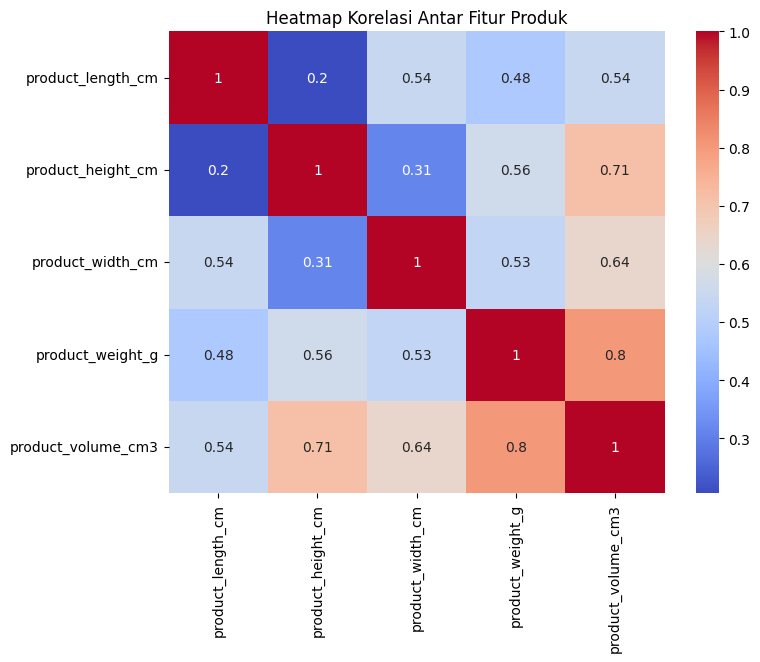

Korelasi tertinggi: product_weight_g dengan product_volume_cm3 (≈ 0.80) menunjukkan semakin besar volume produk maka semakin berat.


In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["product_length_cm","product_height_cm","product_width_cm","product_weight_g","product_volume_cm3"]
corr = prod[num_cols].corr().round(3)
print("Matriks Korelasi:")
display(corr)

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Antar Fitur Produk")
plt.show()

print("Korelasi tertinggi: product_weight_g dengan product_volume_cm3 (≈ 0.80) menunjukkan semakin besar volume produk maka semakin berat.")


## 7. Perhitungan Mean dan Variance (Nomor 4)

Tabel Mean dan Variance per Fitur:


,Mean,Variance
product_length_cm,30.82,2.861300e+02
product_height_cm,16.94,1.860000e+02
product_width_cm,23.20,1.459200e+02
product_weight_g,2276.75,1.833745e+07
product_volume_cm3,16563.38,7.321681e+08


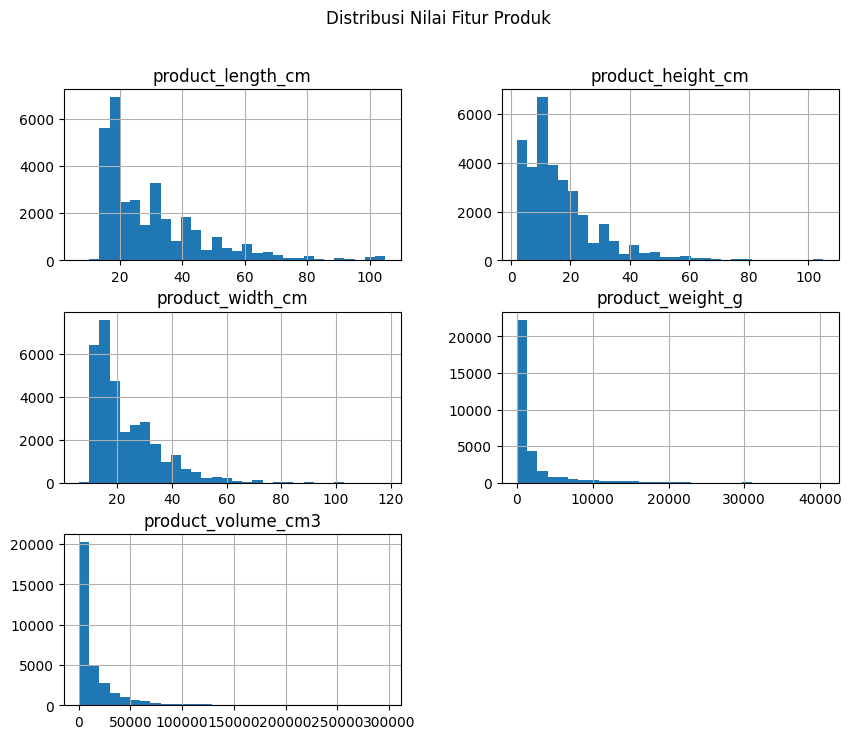

In [ ]:

stats = pd.DataFrame({
    "Mean": prod[num_cols].mean().round(2),
    "Variance": prod[num_cols].var(ddof=1).round(2)
})
print("Tabel Mean dan Variance per Fitur:")
display(stats)

prod[num_cols].hist(figsize=(10,8), bins=30)
plt.suptitle("Distribusi Nilai Fitur Produk")
plt.show()
